In [1]:
import os
import pickle
import sys

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RescaleAction
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

sys.path.append(os.path.abspath(".."))

from rlib.algorithms.offline.dt import (
    DecisionTransformer,
    TrajectoryDataset,
    dt_evaluation,
    dt_train,
)
from rlib.common.buffer import RolloutBuffer
from rlib.common.evaluation import validation

%load_ext autoreload
%autoreload 2

### Environment

In [2]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

discrete = False

reward_norm = 1000

In [3]:
obs_dim = env.observation_space.shape[0]

if discrete:
    action_dim = env.action_space.n
else:
    action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


### Expert

In [139]:
with open("./models/pendulum_stoc_expert", "rb") as file:
    expert_actor = pickle.load(file)

In [140]:
validation(env, expert_actor, deterministic=True)

-165.09818947030627

In [111]:
rb = RolloutBuffer()
rb.collect_rollouts(env, expert_actor, trajectories_n=1000)

In [10]:
data = rb.get_data()

/app/rlib/common/buffer.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(value, dtype=dtype)


In [11]:
torch.save(data, "./models/pendulum_expert_data")

In [165]:
data = torch.load("./models/pendulum_expert_data")

### Expert Data

In [4]:
expert_data = torch.load("./models/pendulum_expert_data_norm_rtg")

In [5]:
rb = RolloutBuffer()
expert_trajectories = rb.get_trajectories(expert_data)

In [6]:
len(expert_trajectories)

3000

### Dataset

In [7]:
K = 3

dataset = TrajectoryDataset(expert_trajectories, K)
print(len(dataset))

594000


In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, (train_size, test_size))
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

### Training

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
trajectory_len = 200

decision_transformer = DecisionTransformer(
    obs_dim,
    action_dim,
    trajectory_len,
    nhead=4,
    num_layers=3,
).to(device)

optimizer = Adam(decision_transformer.parameters(), lr=1e-3)

In [11]:
target_return = -0.1

dt_train(
    decision_transformer,
    env,
    optimizer,
    train_dataloader,
    test_dataloader,
    total_epochs=10,
    device=device,
    target_return=target_return,
    reward_norm=reward_norm,
    K=K,
)

In [32]:
target_return = 0

traj = dt_evaluation(decision_transformer, env, target_return, reward_norm, K)
print(sum(traj["rewards"]))

-126.99720850044842


In [ ]:
# with open("./models/dt_pendulum", "wb") as file:
#    pickle.dump(decision_transformer, file) 

In [29]:
with open("./models/dt_pendulum", "rb") as file:
    decision_transformer = pickle.load(file) 

## db

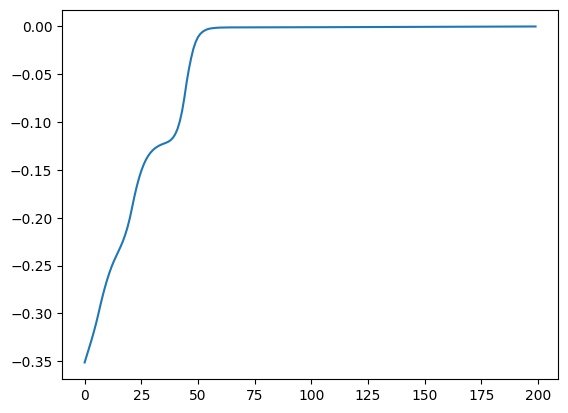

In [37]:
traj = expert_trajectories[4]
# traj = trajectories[0]
i = 100
K = 5

# print(traj["q_estimations"].detach().numpy())
plt.plot(traj["q_estimations"].detach().numpy())

In [35]:
with open("./models/pendulum_stoc_expert", "rb") as file:
    expert_actor = pickle.load(file)

In [39]:
traj = expert_trajectories[101]

In [40]:
i = np.random.randint(0, 150)
K = 1

R = traj["q_estimations"][i : i + K].unsqueeze(0)
s = traj["observations"][i : i + K].unsqueeze(0)
a = traj["actions"][i : i + K].unsqueeze(0)
t = traj["timesteps"][i : i + K].unsqueeze(0)

a = torch.ones_like(a)

R, s, a, t = R.to(device), s.to(device), a.to(device), t.to(device)

a_dt = decision_transformer.forward(R, s, a, t)
a_expert = expert_actor.get_action(s.to("cpu"), deterministic=False)

print(R, s, a, t)

print(a)
print(a_dt)
print(a_expert)

tensor([[[-0.3303]]], device='cuda:0') tensor([[[-0.9948, -0.1018, -0.2531]]], device='cuda:0') tensor([[[1.]]], device='cuda:0') tensor([[[0]]], device='cuda:0')
tensor([[[1.]]], device='cuda:0')
tensor([[[0.9931]]], device='cuda:0', grad_fn=<TanhBackward0>)
(tensor([[[0.9815]]]), tensor([[3.9347]], grad_fn=<ViewBackward0>))


In [41]:
dl = nn.TransformerEncoderLayer(
    d_model=4,
    nhead=1,
    batch_first=True,
)
m = nn.TransformerEncoder(dl, num_layers=1)
m.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
      )
      (linear1): Linear(in_features=4, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=4, bias=True)
      (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [43]:
R_emb = torch.FloatTensor([[[5, 5, 5, 5], [4, 4, 4, 4]]])
s_emb = torch.FloatTensor([[[2, 2, -2, -2], [2, 3, -2, -3]]])
a_emb = torch.FloatTensor([[[0, 0, 1, 1], [0, 1, 1, 0]]])

B, T, C = R_emb.shape
print(B, T, C)

token_emb = torch.stack((R_emb, s_emb, a_emb), dim=1)  # (B, 3, T, C)
# print(token_emb, token_emb.shape)

token_emb = token_emb.permute(0, 2, 1, 3).reshape(B, 3 * T, C)  # (B, 3T, C)
# print(token_emb, token_emb.shape)

mask = nn.Transformer.generate_square_subsequent_mask(3 * T)

out = m.forward(token_emb, mask)
print(out, out.shape)

out = out.reshape(B, T, 3, C).permute(0, 2, 1, 3)  # (B, 3, T, C)
print(out, out.shape)

a_hidden = out[:, 2]
print(a_hidden, a_hidden.shape)

1 2 4
tensor([[[ 0.7409, -1.2096,  1.2034, -0.7347],
         [ 1.4688,  0.0061, -0.1232, -1.3518],
         [ 0.4336, -1.3363,  1.3510, -0.4483],
         [ 0.7409, -1.2096,  1.2034, -0.7347],
         [ 1.1223,  0.6282, -0.2374, -1.5131],
         [ 0.4628, -0.8349,  1.4148, -1.0427]]],
       grad_fn=<NativeLayerNormBackward0>) torch.Size([1, 6, 4])
tensor([[[[ 0.7409, -1.2096,  1.2034, -0.7347],
          [ 0.7409, -1.2096,  1.2034, -0.7347]],

         [[ 1.4688,  0.0061, -0.1232, -1.3518],
          [ 1.1223,  0.6282, -0.2374, -1.5131]],

         [[ 0.4336, -1.3363,  1.3510, -0.4483],
          [ 0.4628, -0.8349,  1.4148, -1.0427]]]], grad_fn=<PermuteBackward0>) torch.Size([1, 3, 2, 4])
tensor([[[ 0.4336, -1.3363,  1.3510, -0.4483],
         [ 0.4628, -0.8349,  1.4148, -1.0427]]], grad_fn=<SelectBackward0>) torch.Size([1, 2, 4])


In [44]:
R_emb = torch.FloatTensor([[[5, 5, 5, 5], [4, 4, 4, 4]]])
s_emb = torch.FloatTensor([[[2, 2, -2, -2], [2, 3, -2, -3]]])
a_emb = torch.FloatTensor([[[10, 0, 1, 1], [0, 1, 1, 0]]])

B, T, C = R_emb.shape
print(B, T, C)

token_emb = torch.stack((R_emb, s_emb, a_emb), dim=1)  # (B, 3, T, C)
# print(token_emb, token_emb.shape)

token_emb = token_emb.permute(0, 2, 1, 3).reshape(B, 3 * T, C)  # (B, 3T, C)
# print(token_emb, token_emb.shape)

mask = nn.Transformer.generate_square_subsequent_mask(3 * T)

out = m.forward(token_emb, mask)
print(out, out.shape)

out = out.reshape(B, T, 3, C).permute(0, 2, 1, 3)  # (B, 3, T, C)
print(out, out.shape)

a_hidden = out[:, 2]
print(a_hidden, a_hidden.shape)

1 2 4
tensor([[[ 0.7409, -1.2096,  1.2034, -0.7347],
         [ 1.4688,  0.0061, -0.1232, -1.3518],
         [ 1.6334, -0.9595, -0.0336, -0.6404],
         [ 0.7427, -1.2112,  1.2016, -0.7331],
         [ 0.7347,  1.1594, -1.3485, -0.5456],
         [ 1.5355, -1.2673, -0.1346, -0.1336]]],
       grad_fn=<NativeLayerNormBackward0>) torch.Size([1, 6, 4])
tensor([[[[ 0.7409, -1.2096,  1.2034, -0.7347],
          [ 0.7427, -1.2112,  1.2016, -0.7331]],

         [[ 1.4688,  0.0061, -0.1232, -1.3518],
          [ 0.7347,  1.1594, -1.3485, -0.5456]],

         [[ 1.6334, -0.9595, -0.0336, -0.6404],
          [ 1.5355, -1.2673, -0.1346, -0.1336]]]], grad_fn=<PermuteBackward0>) torch.Size([1, 3, 2, 4])
tensor([[[ 1.6334, -0.9595, -0.0336, -0.6404],
         [ 1.5355, -1.2673, -0.1346, -0.1336]]], grad_fn=<SelectBackward0>) torch.Size([1, 2, 4])


In [45]:
obs, _ = env.reset()
action = np.array([0.9])

R = torch.tensor(target_return, dtype=torch.float32, device=device).reshape(1, 1, 1)
s = torch.tensor(obs, dtype=torch.float32, device=device).reshape(1, 1, -1)
a = torch.tensor(action, dtype=torch.float32, device=device).reshape(1, 1, -1)
t = torch.tensor(0, device=device).reshape(1, 1, 1)

print(R, s, a, t)

while True:
    with torch.no_grad():
        a_pred = decision_transformer.forward(R, s, a, t)[:, -1, :]
        # print(model.forward(R, s, a, t))
        print(a_pred)
        print(expert_actor.get_action(s.to("cpu"))[0])
        print()

    break

tensor([[[-1.]]], device='cuda:0') tensor([[[-0.4412,  0.8974, -0.2152]]], device='cuda:0') tensor([[[0.9000]]], device='cuda:0') tensor([[[0]]], device='cuda:0')
tensor([[0.9958]], device='cuda:0')
tensor([[[1.0162]]])



In [ ]:
import matplotlib.pyplot as plt

real_actions = []
pred_actions = []

for i in range(15):  # 100 рандомных примеров
    R = traj["q_estimations"][i : i + K].unsqueeze(0).to(device)
    s = traj["observations"][i : i + K].unsqueeze(0).to(device)
    a = traj["actions"][i : i + K].unsqueeze(0).to(device)
    t = traj["timesteps"][i : i + K].unsqueeze(0).to(device)

    a_pred = decision_transformer.forward(R, s, a, t).detach().cpu().numpy()

    real_actions.extend(a.cpu().numpy().flatten())
    pred_actions.extend(a_pred.flatten())

plt.plot(real_actions, label="Real")
plt.plot(pred_actions, label="Predicted", linestyle="dashed")
plt.legend()
plt.show()

In [36]:
def compare(target_return=-150):
    obs, _ = env.reset()

    # action, _ = expert_actor.predict(obs, deterministic=True)
    action = env.action_space.sample()

    R = torch.tensor(target_return, dtype=torch.float32, device=device).reshape(1, 1, 1)
    s = torch.tensor(obs, dtype=torch.float32, device=device).reshape(1, 1, -1)
    a = torch.tensor(action, dtype=torch.float32, device=device).reshape(1, 1, -1)
    t = torch.tensor(0, device=device).reshape(1, 1, 1)

    rewards = []
    expert_actions = []
    dt_actions = []

    while True:
        with torch.no_grad():
            a_pred = decision_transformer.forward(R, s, a, t)[:, -1, :]
        a_pred = a_pred.reshape(1, 1, -1)

        dt_action = a_pred.squeeze().cpu().detach().numpy()
        expert_action, _ = expert_actor.predict(obs, deterministic=True)

        next_obs, reward, terminated, truncated, _ = env.step(expert_action)

        obs = next_obs

        rewards.append(reward)

        reward /= reward_norm
        next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device).reshape(
            1, 1, -1
        )
        reward = torch.tensor(reward, dtype=torch.float32, device=device).reshape(
            1, 1, 1
        )

        return_to_go = R[:, -1, :] - reward
        timestep = t[:, -1, :] + 1
        timestep = timestep.reshape(1, 1, 1)

        R = torch.cat((R, return_to_go), dim=1)[:, -K:, :]
        s = torch.cat((s, next_obs), dim=1)[:, -K:, :]
        a = torch.cat((a, a_pred), dim=1)[:, -K:, :]
        t = torch.cat((t, timestep), dim=1)[:, -K:, :]

        if terminated or truncated:
            break

        expert_actions.append(expert_action)
        dt_actions.append(dt_action)

    plt.figure(figsize=(9, 5))
    plt.plot(expert_actions, label=f"Expert Episode", linestyle="solid")
    plt.plot(dt_actions, label=f"DT Episode", linestyle="dashed")

    plt.ylim((-1.2, 1.2))
    plt.xlabel("Timesteps")
    plt.ylabel("Action")
    plt.title("Comparison of Expert and DT Actions")
    plt.legend()
    plt.show()

    print(sum(rewards))

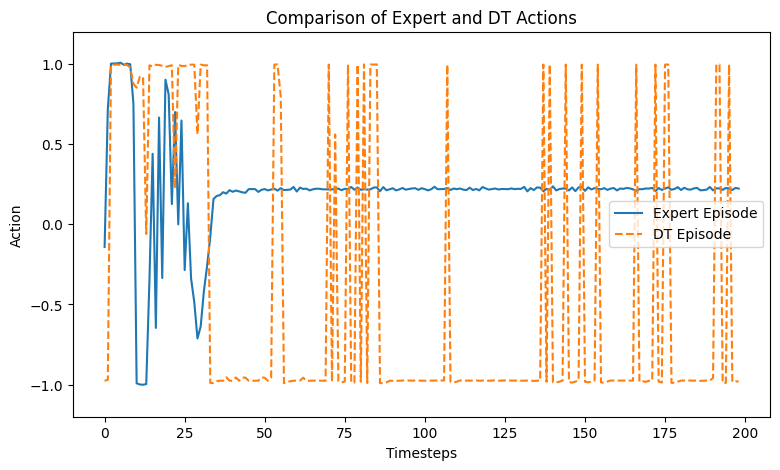

-126.80361219705013


In [40]:
compare(target_return=1000)

In [ ]:
evaluation(decision_transformer, env, -150, 5)

In [270]:
B, T, C = 2, 4, 3

In [271]:
R = 1 * torch.ones((B, T, C))
s = 2 * torch.ones((B, T, C))
a = 3 * torch.ones((B, T, C))

In [272]:
tokens = torch.cat((R, s, a), dim=1)
tokens

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]]])

In [276]:
tokens = torch.stack((R, s, a), dim=2)
tokens.shape, tokens

(torch.Size([2, 4, 3, 3]),
 tensor([[[[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]]],
 
 
         [[[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]],
 
          [[1., 1., 1.],
           [2., 2., 2.],
           [3., 3., 3.]]]]))

In [262]:
batch = next(iter(dataloader))

In [263]:
batch

[tensor([[[-51.6459],
          [-54.7376],
          [-58.0769],
          [-61.2564],
          [-63.7972]]]),
 tensor([[[ 0.0372, -0.9993,  0.5102],
          [ 0.0102, -0.9999, -0.5390],
          [-0.0692, -0.9976, -1.5889],
          [-0.1997, -0.9799, -2.6371],
          [-0.3753, -0.9269, -3.6720]]]),
 tensor([[[-0.9991],
          [-0.9997],
          [-1.0002],
          [-1.0001],
          [-0.9999]]]),
 tensor([[0, 1, 2, 3, 4]])]

In [ ]:
num_embeddings = 10
embedding_dim = 32

emb_table = nn.Embedding(num_embeddings, embedding_dim)

In [ ]:
embedding_dim = 32

decoder_layer = nn.TransformerDecoderLayer(
    d_model=embedding_dim,
    nhead=4,
    batch_first=True,
)

transformer = nn.TransformerDecoder(decoder_layer, num_layers=3)

B = 4
T = 10
C = embedding_dim

tgt = torch.zeros((B, T, C))
tgt_mask = nn.Transformer.generate_square_subsequent_mask(T)

memory = torch.zeros((B, 1, C))

transformer.forward(
    tgt=tgt,
    memory=memory,
    tgt_mask=tgt_mask,
).shape

torch.Size([4, 10, 32])